# Upstream Regulator Analysis Package
## Arthritis Case Study
### Direct Module Use, No Wrapper Class

----------------------

Author: Mikayla Webster (m1webste@ucsd.edu)

Date: 19th January, 2018

----------------------

<a id='toc'></a>
## Table of Contents
1. [Background](#background)
2. [Import packages](#import)
3. [Load Networks](#load)
6. [P-value and Z-score Calculation](#pz)
8. [Display Our results](#display)

## Background
<a id='background'></a>

The inspiration for these modules comes from Ingenuity System's [Ingenuity Upstream Regulator Analysis in IPA®](http://pages.ingenuity.com/rs/ingenuity/images/0812%20upstream_regulator_analysis_whitepaper.pdf).

This notebook demonstrates how to use our ura package WITHOUT the use of our "wrapper class" Upstream. This notebook directly calls all the functions from modules create_graph and stat_analysis. This notebook emphasizes the flow of function calls, namely what order you should call functions in order for the workflow to process correctly. If you need further help on how to use a function or what that function's purpose is, see the comments associated with that function in the source code (create_graph.py or stat_analysis.py).

## Import packages
<a id='import'></a>

In [1]:
# import upstream regulator modules
import sys
code_path = '../../ura'
sys.path.append(code_path)
import create_graph
import stat_analysis
reload(create_graph)
reload(stat_analysis)

<module 'stat_analysis' from '../../ura\stat_analysis.pyc'>

In [12]:
%matplotlib inline

In [2]:
# User preferences
symbol = 'symbol'
entrez = 'entrez'

gene_type = symbol

## Load Networks
<a id='load'></a>

1. List of all **Transcription Factors** (TF's) or regulators of interest to us
    <br>
    - Our sources are [slowkow](https://github.com/slowkow/tftargets) and [jaspar](http://jaspar.genereg.net/) TF databases
    <br><br>
2. **Background Network**: [STRING human protein interactions network](https://string-db.org/cgi/download.pl?UserId=9BGA8WkVMRl6&sessionId=HWUK6Dum9xC6&species_text=Homo+sapiens)  
    - Filter our background network down to just the sub network of TF's and their targets
    <br><br>
3. User-supplied list of **Differentially Expressed Genes** (DEG's)

In [3]:
# transcription factors
TF_list = create_graph.easy_load_TF_list(slowkow_bool=True, jaspar_bool=True, gene_type = gene_type)
print "Number of TF's: " + str(len(TF_list))

Number of TF's: 3983


In [4]:
# background network
filename = "../../background_networks/9606.protein.actions.v10.5.txt"
confidence_filter = 400
DG_TF, DG_universe = create_graph.load_STRING_to_digraph(filename, TF_list, confidence_filter, gene_type)

print "\nNumber of interactions: " + str(len(list(DG_TF.edges())))

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-7374...done.
Finished.
56 input query terms found dup hits:
	[(u'ENSP00000359550', 3), (u'ENSP00000447879', 2), (u'ENSP00000364076', 2), (u'ENSP00000348986', 2),
312 input query terms found no hit:
	[u'ENSP00000376684', u'ENSP00000289352', u'ENSP00000202788', u'ENSP00000373637', u'ENSP00000367802',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.

Number of interactions: 28939


In [5]:
# differentially expressed genes
reload(create_graph)
DEG_filename = "../../DEG_databases/DE_Coeff_OAvsNormal_OAvsNormal_20171215.csv" 
DEG_list, DG_TF = create_graph.create_DEG_list(DEG_filename, DG_TF, # adding DEG up-down information to our graph
                                               p_value_filter = 0.05, # p < 0.05
                                               fold_change_filter = 1, # |fld| > 1
                                               gene_type = gene_type)

DEG_full_graph, DEG_to_pvalue, DEG_to_updown = create_graph.create_DEG_full_graph(DEG_filename, gene_type = gene_type)

print "Number of DEG's: " + str(len(DEG_list))

Number of DEG's: 1456


## P-values and Z-score Calculation
<a id='pz'></a>

1. **P-values**: How relevant is a TF to its DEG targets? Are they connected by chance, or is their connection statistically significant?
    <br>
    1. -log(p-value) for each TF using [scipy.stats.hypergeom.logsf](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.hypergeom.html).
        1. high value = significant connection between this TF and its DEG targets
        2. low value = TF is randomly associated with its DEG targets
        3. zero = None of this TF's targets were DEG's
        4. inf = original p-value was so small that its log is inf. Very high significance.
        <br><br>
2. **Z-scores**: Goal is to predict the activation states of the TF's

    - activation states: interaction type/regulation direction = predicted state
        - activating/up  = activating
        - activating/down = inhibiting
        - inhibiting/up = inhibiting
        - inhibiting/down = activating
        <br><br>
    - unbiased vs biased calculations:
        - **unbiased calculation**: Assume a normal distribution of activating and inhibiting states 
        - **biased calculation**: For the case when you cannot assume a 50-50 split between up/down-regulated targets and activating/inhbiting interactions. Modify our formula to approximate a normal distribution.

In [6]:
# Enrichment of every TF with respect to its targets
p_values = stat_analysis.tf_target_enrichment(DG_TF, DG_universe, DEG_list)

# Enrichment of TF's themselves
tf_enrich = stat_analysis.tf_enrichment(TF_list, DEG_full_graph, DEG_list)    

In [7]:
z_scores = stat_analysis.tf_zscore(DG_TF, DEG_list, bias_filter = 0.25) # recommended bias filter is 0.25

## Display Our Results
<a id='display'></a>
- Display TF's with top z-scores
- Display where certain TF's rank among others and overall according to z-score
- Display subnetwork of a particular TF and its targets

In [8]:
top_overall = stat_analysis.top_values(z_scores, DEG_to_pvalue, DEG_to_updown, act = False, abs_value = True, top = 10)
display(top_overall)

,z-score,(adj) p-value,(log) fold change
RBL2,-3.162278,0.129498,-0.830733
GLI2,-2.828427,0.172742,-0.554695
FOXO3,-2.710687,0.000292,-1.125810
CLIP1,2.672612,0.042270,-0.521127
CKAP5,2.672612,0.866232,-0.071815
MAD1L1,2.672612,0.039497,-0.561039
CENPA,2.672612,NaN,NaN
BUB3,2.672612,0.045374,0.264598
AHCTF1,2.672612,0.043979,-0.401034
STAT1,2.840188,0.826469,0.063822


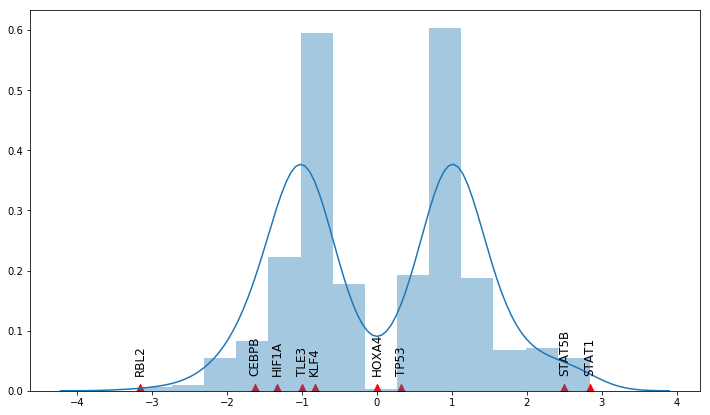

In [13]:
# Ranking (in this case from 0 to 168)
genes_to_rank = ['HOXA4', 'CEBPB', 'HIF1A','KLF4', 'TLE3', 'RBL2','TP53', 'STAT1', 'STAT5B']
stat_analysis.compare_genes(z_scores, genes_to_rank)

In [ ]:
stat_analysis.vis_tf_network(DG_TF, 'STAT1', '../../DEG_databases/geo2r_GSE11352_brca_48hours.txt', DEG_list,
              directed_edges = True,
              node_spacing = 1500,
              color_non_DEGs = False,
              graph_id = 20) 

In [ ]:
# display subnetworks using visJS2jupyter
stat_analysis.vis_tf_network(DG_TF, 'STAT1', '../../DEG_databases/geo2r_GSE11352_brca_48hours.txt', DEG_list,
              directed_edges = False,
              node_spacing = 2500,
              color_non_DEGs = True,
              tf_size_amplifier = 12,
              graph_id = 21) 

In [ ]:
stat_analysis.to_csv(out_filename = 'example_arthritis.txt', 
                     z_score_series = z_scores, 
                     DEG_to_pvalue = DEG_to_pvalue, 
                     DEG_to_updown = DEG_to_updown, 
                     tf_target_enrichment = tf_enrich, 
                     DG_TF = DG_TF)